In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/nih-chest-x-rays-preprocessed-version/README_CHESTXRAY.pdf
/kaggle/input/nih-chest-x-rays-preprocessed-version/BBox_List_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/test_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/Data_Entry_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/train_val_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006199_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004833_016.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006260_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004911_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004186_007.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004459_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00005004_001.png
/kaggle/input/nih-chest-x-rays-preproc

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import densenet121, DenseNet121_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "replication_of_dannynet",
    "batch_size": 8,
    "learning_rate": 0.00005,
    "epochs": 25,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/nih-chest-x-rays-preprocessed-version",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 42,
    "image_size": 224,
}

In [5]:
print(CONFIG["device"])

cuda


In [6]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# ---------------- MODEL ---------------- #
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 14)
model = model.to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 203MB/s]


In [8]:
# ---------------- LOSS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [9]:
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

In [10]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

In [11]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [12]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [13]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=CONFIG["seed"])
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [14]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [15]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [16]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [17]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [18]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [19]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [21]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [22]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/25
----------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7986 | F1: 0.3938
[Validate] Cardiomegaly AUC: 0.8777 | F1: 0.3394
[Validate] Consolidation AUC: 0.7924 | F1: 0.2134
[Validate] Edema AUC: 0.8555 | F1: 0.1733
[Validate] Effusion AUC: 0.8475 | F1: 0.5148
[Validate] Emphysema AUC: 0.9056 | F1: 0.4266
[Validate] Fibrosis AUC: 0.8130 | F1: 0.1173
[Validate] Hernia AUC: 0.8772 | F1: 0.1389
[Validate] Infiltration AUC: 0.6943 | F1: 0.4085
[Validate] Mass AUC: 0.8079 | F1: 0.3585
[Validate] Nodule AUC: 0.7456 | F1: 0.2781
[Validate] Pleural_Thickening AUC: 0.7979 | F1: 0.2137
[Validate] Pneumonia AUC: 0.6816 | F1: 0.0535
[Validate] Pneumothorax AUC: 0.8712 | F1: 0.4110
[Validate] Avg AUC: 0.8119, Avg F1: 0.2886
Training Loss: 0.0469
Validation Loss: 0.0419
Validation AUC: 0.8119
Validation F1: 0.2886
✓ NEW BEST MODEL! Saved at models/best_model_20250913-152550.pth

Epoch 2/25
----------------------------------------


Epoch 2/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8157 | F1: 0.4005
[Validate] Cardiomegaly AUC: 0.8632 | F1: 0.3430
[Validate] Consolidation AUC: 0.7937 | F1: 0.2405
[Validate] Edema AUC: 0.8554 | F1: 0.1767
[Validate] Effusion AUC: 0.8511 | F1: 0.4947
[Validate] Emphysema AUC: 0.8860 | F1: 0.4524
[Validate] Fibrosis AUC: 0.8253 | F1: 0.1455
[Validate] Hernia AUC: 0.8948 | F1: 0.2500
[Validate] Infiltration AUC: 0.7043 | F1: 0.4255
[Validate] Mass AUC: 0.8198 | F1: 0.3602
[Validate] Nodule AUC: 0.7538 | F1: 0.3279
[Validate] Pleural_Thickening AUC: 0.7946 | F1: 0.2361
[Validate] Pneumonia AUC: 0.7109 | F1: 0.0697
[Validate] Pneumothorax AUC: 0.8754 | F1: 0.4127
[Validate] Avg AUC: 0.8174, Avg F1: 0.3097
Training Loss: 0.0442
Validation Loss: 0.0419
Validation AUC: 0.8174
Validation F1: 0.3097
✓ NEW BEST MODEL! Saved at models/best_model_20250913-155023.pth

Epoch 3/25
----------------------------------------


Epoch 3/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8288 | F1: 0.4172
[Validate] Cardiomegaly AUC: 0.8721 | F1: 0.3652
[Validate] Consolidation AUC: 0.8029 | F1: 0.2519
[Validate] Edema AUC: 0.8659 | F1: 0.1808
[Validate] Effusion AUC: 0.8617 | F1: 0.5125
[Validate] Emphysema AUC: 0.8992 | F1: 0.4945
[Validate] Fibrosis AUC: 0.8085 | F1: 0.1373
[Validate] Hernia AUC: 0.9000 | F1: 0.3750
[Validate] Infiltration AUC: 0.7131 | F1: 0.4299
[Validate] Mass AUC: 0.8455 | F1: 0.3929
[Validate] Nodule AUC: 0.7371 | F1: 0.3108
[Validate] Pleural_Thickening AUC: 0.8027 | F1: 0.2533
[Validate] Pneumonia AUC: 0.7110 | F1: 0.0668
[Validate] Pneumothorax AUC: 0.8629 | F1: 0.4013
[Validate] Avg AUC: 0.8222, Avg F1: 0.3278
Training Loss: 0.0433
Validation Loss: 0.0412
Validation AUC: 0.8222
Validation F1: 0.3278
✓ NEW BEST MODEL! Saved at models/best_model_20250913-161505.pth

Epoch 4/25
----------------------------------------


Epoch 4/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8307 | F1: 0.4057
[Validate] Cardiomegaly AUC: 0.8730 | F1: 0.3773
[Validate] Consolidation AUC: 0.8100 | F1: 0.2643
[Validate] Edema AUC: 0.8724 | F1: 0.1867
[Validate] Effusion AUC: 0.8655 | F1: 0.5168
[Validate] Emphysema AUC: 0.9193 | F1: 0.4981
[Validate] Fibrosis AUC: 0.8439 | F1: 0.1628
[Validate] Hernia AUC: 0.9433 | F1: 0.4286
[Validate] Infiltration AUC: 0.7073 | F1: 0.4291
[Validate] Mass AUC: 0.8370 | F1: 0.4021
[Validate] Nodule AUC: 0.7616 | F1: 0.3272
[Validate] Pleural_Thickening AUC: 0.8209 | F1: 0.2500
[Validate] Pneumonia AUC: 0.7268 | F1: 0.0768
[Validate] Pneumothorax AUC: 0.8671 | F1: 0.4245
[Validate] Avg AUC: 0.8342, Avg F1: 0.3393
Training Loss: 0.0427
Validation Loss: 0.0404
Validation AUC: 0.8342
Validation F1: 0.3393
✓ NEW BEST MODEL! Saved at models/best_model_20250913-163938.pth

Epoch 5/25
----------------------------------------


Epoch 5/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8305 | F1: 0.4106
[Validate] Cardiomegaly AUC: 0.8690 | F1: 0.3869
[Validate] Consolidation AUC: 0.7938 | F1: 0.2418
[Validate] Edema AUC: 0.8896 | F1: 0.2242
[Validate] Effusion AUC: 0.8666 | F1: 0.5054
[Validate] Emphysema AUC: 0.9129 | F1: 0.4769
[Validate] Fibrosis AUC: 0.8368 | F1: 0.1807
[Validate] Hernia AUC: 0.9370 | F1: 0.4211
[Validate] Infiltration AUC: 0.7083 | F1: 0.4157
[Validate] Mass AUC: 0.8505 | F1: 0.3796
[Validate] Nodule AUC: 0.7652 | F1: 0.3428
[Validate] Pleural_Thickening AUC: 0.8194 | F1: 0.2552
[Validate] Pneumonia AUC: 0.7174 | F1: 0.0804
[Validate] Pneumothorax AUC: 0.8729 | F1: 0.3856
[Validate] Avg AUC: 0.8336, Avg F1: 0.3362
Training Loss: 0.0423
Validation Loss: 0.0406
Validation AUC: 0.8336
Validation F1: 0.3362
No improvement. Patience: 1/5

Epoch 6/25
----------------------------------------


Epoch 6/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8333 | F1: 0.4191
[Validate] Cardiomegaly AUC: 0.8966 | F1: 0.3778
[Validate] Consolidation AUC: 0.8022 | F1: 0.2429
[Validate] Edema AUC: 0.8859 | F1: 0.2190
[Validate] Effusion AUC: 0.8661 | F1: 0.5128
[Validate] Emphysema AUC: 0.9111 | F1: 0.5217
[Validate] Fibrosis AUC: 0.8242 | F1: 0.1854
[Validate] Hernia AUC: 0.9478 | F1: 0.5238
[Validate] Infiltration AUC: 0.7032 | F1: 0.4147
[Validate] Mass AUC: 0.8267 | F1: 0.3865
[Validate] Nodule AUC: 0.7571 | F1: 0.3320
[Validate] Pleural_Thickening AUC: 0.8102 | F1: 0.2496
[Validate] Pneumonia AUC: 0.7082 | F1: 0.0607
[Validate] Pneumothorax AUC: 0.8883 | F1: 0.4341
[Validate] Avg AUC: 0.8329, Avg F1: 0.3486
Training Loss: 0.0419
Validation Loss: 0.0403
Validation AUC: 0.8329
Validation F1: 0.3486
No improvement. Patience: 2/5

Epoch 7/25
----------------------------------------


Epoch 7/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8402 | F1: 0.4141
[Validate] Cardiomegaly AUC: 0.8743 | F1: 0.3832
[Validate] Consolidation AUC: 0.8120 | F1: 0.2518
[Validate] Edema AUC: 0.8840 | F1: 0.2108
[Validate] Effusion AUC: 0.8650 | F1: 0.5142
[Validate] Emphysema AUC: 0.9228 | F1: 0.4912
[Validate] Fibrosis AUC: 0.8202 | F1: 0.1871
[Validate] Hernia AUC: 0.9447 | F1: 0.4390
[Validate] Infiltration AUC: 0.7154 | F1: 0.4280
[Validate] Mass AUC: 0.8581 | F1: 0.4183
[Validate] Nodule AUC: 0.7906 | F1: 0.3584
[Validate] Pleural_Thickening AUC: 0.8368 | F1: 0.2817
[Validate] Pneumonia AUC: 0.6936 | F1: 0.0722
[Validate] Pneumothorax AUC: 0.8805 | F1: 0.4070
[Validate] Avg AUC: 0.8384, Avg F1: 0.3469
Training Loss: 0.0417
Validation Loss: 0.0404
Validation AUC: 0.8384
Validation F1: 0.3469
✓ NEW BEST MODEL! Saved at models/best_model_20250913-175544.pth

Epoch 8/25
----------------------------------------


Epoch 8/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8320 | F1: 0.4152
[Validate] Cardiomegaly AUC: 0.8809 | F1: 0.3788
[Validate] Consolidation AUC: 0.8104 | F1: 0.2592
[Validate] Edema AUC: 0.8890 | F1: 0.2129
[Validate] Effusion AUC: 0.8664 | F1: 0.4951
[Validate] Emphysema AUC: 0.9158 | F1: 0.4691
[Validate] Fibrosis AUC: 0.8173 | F1: 0.1550
[Validate] Hernia AUC: 0.9268 | F1: 0.4681
[Validate] Infiltration AUC: 0.7195 | F1: 0.4310
[Validate] Mass AUC: 0.8479 | F1: 0.3870
[Validate] Nodule AUC: 0.7792 | F1: 0.3416
[Validate] Pleural_Thickening AUC: 0.8321 | F1: 0.2842
[Validate] Pneumonia AUC: 0.7318 | F1: 0.0816
[Validate] Pneumothorax AUC: 0.8845 | F1: 0.4339
[Validate] Avg AUC: 0.8381, Avg F1: 0.3438
Training Loss: 0.0414
Validation Loss: 0.0407
Validation AUC: 0.8381
Validation F1: 0.3438
No improvement. Patience: 1/5

Epoch 9/25
----------------------------------------


Epoch 9/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8443 | F1: 0.4300
[Validate] Cardiomegaly AUC: 0.8914 | F1: 0.3837
[Validate] Consolidation AUC: 0.8173 | F1: 0.2689
[Validate] Edema AUC: 0.8899 | F1: 0.2341
[Validate] Effusion AUC: 0.8764 | F1: 0.5112
[Validate] Emphysema AUC: 0.9227 | F1: 0.4759
[Validate] Fibrosis AUC: 0.8396 | F1: 0.2025
[Validate] Hernia AUC: 0.9454 | F1: 0.5106
[Validate] Infiltration AUC: 0.7196 | F1: 0.4288
[Validate] Mass AUC: 0.8688 | F1: 0.4059
[Validate] Nodule AUC: 0.7837 | F1: 0.3719
[Validate] Pleural_Thickening AUC: 0.8412 | F1: 0.2898
[Validate] Pneumonia AUC: 0.7506 | F1: 0.0973
[Validate] Pneumothorax AUC: 0.8990 | F1: 0.4333
[Validate] Avg AUC: 0.8493, Avg F1: 0.3603
Training Loss: 0.0402
Validation Loss: 0.0392
Validation AUC: 0.8493
Validation F1: 0.3603
✓ NEW BEST MODEL! Saved at models/best_model_20250913-184551.pth

Epoch 10/25
----------------------------------------


Epoch 10/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8469 | F1: 0.4355
[Validate] Cardiomegaly AUC: 0.8909 | F1: 0.3936
[Validate] Consolidation AUC: 0.8201 | F1: 0.2769
[Validate] Edema AUC: 0.8896 | F1: 0.2241
[Validate] Effusion AUC: 0.8784 | F1: 0.5221
[Validate] Emphysema AUC: 0.9262 | F1: 0.4915
[Validate] Fibrosis AUC: 0.8369 | F1: 0.2126
[Validate] Hernia AUC: 0.9462 | F1: 0.5106
[Validate] Infiltration AUC: 0.7234 | F1: 0.4351
[Validate] Mass AUC: 0.8699 | F1: 0.4029
[Validate] Nodule AUC: 0.7823 | F1: 0.3630
[Validate] Pleural_Thickening AUC: 0.8427 | F1: 0.2857
[Validate] Pneumonia AUC: 0.7490 | F1: 0.0914
[Validate] Pneumothorax AUC: 0.8944 | F1: 0.4160
[Validate] Avg AUC: 0.8498, Avg F1: 0.3615
Training Loss: 0.0398
Validation Loss: 0.0390
Validation AUC: 0.8498
Validation F1: 0.3615
✓ NEW BEST MODEL! Saved at models/best_model_20250913-191026.pth

Epoch 11/25
----------------------------------------


Epoch 11/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8465 | F1: 0.4331
[Validate] Cardiomegaly AUC: 0.8873 | F1: 0.3857
[Validate] Consolidation AUC: 0.8213 | F1: 0.2724
[Validate] Edema AUC: 0.8914 | F1: 0.2429
[Validate] Effusion AUC: 0.8771 | F1: 0.5174
[Validate] Emphysema AUC: 0.9235 | F1: 0.4850
[Validate] Fibrosis AUC: 0.8269 | F1: 0.2250
[Validate] Hernia AUC: 0.9375 | F1: 0.5217
[Validate] Infiltration AUC: 0.7244 | F1: 0.4359
[Validate] Mass AUC: 0.8684 | F1: 0.3994
[Validate] Nodule AUC: 0.7799 | F1: 0.3653
[Validate] Pleural_Thickening AUC: 0.8447 | F1: 0.2744
[Validate] Pneumonia AUC: 0.7451 | F1: 0.0884
[Validate] Pneumothorax AUC: 0.8977 | F1: 0.4195
[Validate] Avg AUC: 0.8480, Avg F1: 0.3619
Training Loss: 0.0396
Validation Loss: 0.0393
Validation AUC: 0.8480
Validation F1: 0.3619
No improvement. Patience: 1/5

Epoch 12/25
----------------------------------------


Epoch 12/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8481 | F1: 0.4353
[Validate] Cardiomegaly AUC: 0.8881 | F1: 0.3825
[Validate] Consolidation AUC: 0.8204 | F1: 0.2730
[Validate] Edema AUC: 0.8931 | F1: 0.2484
[Validate] Effusion AUC: 0.8777 | F1: 0.5217
[Validate] Emphysema AUC: 0.9275 | F1: 0.5211
[Validate] Fibrosis AUC: 0.8332 | F1: 0.1967
[Validate] Hernia AUC: 0.9423 | F1: 0.5106
[Validate] Infiltration AUC: 0.7229 | F1: 0.4360
[Validate] Mass AUC: 0.8721 | F1: 0.4098
[Validate] Nodule AUC: 0.7780 | F1: 0.3708
[Validate] Pleural_Thickening AUC: 0.8419 | F1: 0.2693
[Validate] Pneumonia AUC: 0.7500 | F1: 0.0794
[Validate] Pneumothorax AUC: 0.8985 | F1: 0.4243
[Validate] Avg AUC: 0.8496, Avg F1: 0.3628
Training Loss: 0.0395
Validation Loss: 0.0391
Validation AUC: 0.8496
Validation F1: 0.3628
No improvement. Patience: 2/5

Epoch 13/25
----------------------------------------


Epoch 13/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8479 | F1: 0.4380
[Validate] Cardiomegaly AUC: 0.8910 | F1: 0.3774
[Validate] Consolidation AUC: 0.8197 | F1: 0.2723
[Validate] Edema AUC: 0.8929 | F1: 0.2380
[Validate] Effusion AUC: 0.8784 | F1: 0.5177
[Validate] Emphysema AUC: 0.9289 | F1: 0.5286
[Validate] Fibrosis AUC: 0.8371 | F1: 0.1978
[Validate] Hernia AUC: 0.9437 | F1: 0.5106
[Validate] Infiltration AUC: 0.7219 | F1: 0.4317
[Validate] Mass AUC: 0.8697 | F1: 0.4062
[Validate] Nodule AUC: 0.7780 | F1: 0.3660
[Validate] Pleural_Thickening AUC: 0.8443 | F1: 0.2650
[Validate] Pneumonia AUC: 0.7505 | F1: 0.0913
[Validate] Pneumothorax AUC: 0.8990 | F1: 0.4277
[Validate] Avg AUC: 0.8502, Avg F1: 0.3620
Training Loss: 0.0393
Validation Loss: 0.0391
Validation AUC: 0.8502
Validation F1: 0.3620
✓ NEW BEST MODEL! Saved at models/best_model_20250913-202420.pth

Epoch 14/25
----------------------------------------


Epoch 14/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8487 | F1: 0.4430
[Validate] Cardiomegaly AUC: 0.8861 | F1: 0.3772
[Validate] Consolidation AUC: 0.8206 | F1: 0.2750
[Validate] Edema AUC: 0.8930 | F1: 0.2452
[Validate] Effusion AUC: 0.8792 | F1: 0.5176
[Validate] Emphysema AUC: 0.9291 | F1: 0.5284
[Validate] Fibrosis AUC: 0.8302 | F1: 0.2083
[Validate] Hernia AUC: 0.9440 | F1: 0.5106
[Validate] Infiltration AUC: 0.7215 | F1: 0.4323
[Validate] Mass AUC: 0.8713 | F1: 0.4080
[Validate] Nodule AUC: 0.7802 | F1: 0.3610
[Validate] Pleural_Thickening AUC: 0.8452 | F1: 0.2808
[Validate] Pneumonia AUC: 0.7522 | F1: 0.0875
[Validate] Pneumothorax AUC: 0.8996 | F1: 0.4265
[Validate] Avg AUC: 0.8501, Avg F1: 0.3644
Training Loss: 0.0393
Validation Loss: 0.0391
Validation AUC: 0.8501
Validation F1: 0.3644
No improvement. Patience: 1/5

Epoch 15/25
----------------------------------------


Epoch 15/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d1c7d370040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7d1c7d370040>
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()^^
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^^
 ^ ^  ^^ 
    File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^^^^^ ^ ^ ^  ^
   File "/usr/lib

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8478 | F1: 0.4410
[Validate] Cardiomegaly AUC: 0.8888 | F1: 0.3769
[Validate] Consolidation AUC: 0.8192 | F1: 0.2737
[Validate] Edema AUC: 0.8940 | F1: 0.2391
[Validate] Effusion AUC: 0.8789 | F1: 0.5164
[Validate] Emphysema AUC: 0.9299 | F1: 0.5260
[Validate] Fibrosis AUC: 0.8322 | F1: 0.2065
[Validate] Hernia AUC: 0.9451 | F1: 0.5106
[Validate] Infiltration AUC: 0.7212 | F1: 0.4322
[Validate] Mass AUC: 0.8691 | F1: 0.4014
[Validate] Nodule AUC: 0.7788 | F1: 0.3594
[Validate] Pleural_Thickening AUC: 0.8448 | F1: 0.2729
[Validate] Pneumonia AUC: 0.7509 | F1: 0.0924
[Validate] Pneumothorax AUC: 0.8993 | F1: 0.4281
[Validate] Avg AUC: 0.8500, Avg F1: 0.3626
Training Loss: 0.0392
Validation Loss: 0.0392
Validation AUC: 0.8500
Validation F1: 0.3626
No improvement. Patience: 2/5

Epoch 16/25
----------------------------------------


Epoch 16/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8488 | F1: 0.4393
[Validate] Cardiomegaly AUC: 0.8906 | F1: 0.3785
[Validate] Consolidation AUC: 0.8198 | F1: 0.2730
[Validate] Edema AUC: 0.8937 | F1: 0.2480
[Validate] Effusion AUC: 0.8789 | F1: 0.5206
[Validate] Emphysema AUC: 0.9302 | F1: 0.5263
[Validate] Fibrosis AUC: 0.8339 | F1: 0.2184
[Validate] Hernia AUC: 0.9449 | F1: 0.5106
[Validate] Infiltration AUC: 0.7228 | F1: 0.4333
[Validate] Mass AUC: 0.8707 | F1: 0.4096
[Validate] Nodule AUC: 0.7796 | F1: 0.3689
[Validate] Pleural_Thickening AUC: 0.8464 | F1: 0.2719
[Validate] Pneumonia AUC: 0.7508 | F1: 0.0889
[Validate] Pneumothorax AUC: 0.8979 | F1: 0.4214
[Validate] Avg AUC: 0.8506, Avg F1: 0.3649
Training Loss: 0.0392
Validation Loss: 0.0391
Validation AUC: 0.8506
Validation F1: 0.3649
✓ NEW BEST MODEL! Saved at models/best_model_20250913-213832.pth

Epoch 17/25
----------------------------------------


Epoch 17/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8480 | F1: 0.4423
[Validate] Cardiomegaly AUC: 0.8867 | F1: 0.3794
[Validate] Consolidation AUC: 0.8196 | F1: 0.2713
[Validate] Edema AUC: 0.8926 | F1: 0.2489
[Validate] Effusion AUC: 0.8788 | F1: 0.5146
[Validate] Emphysema AUC: 0.9309 | F1: 0.5153
[Validate] Fibrosis AUC: 0.8334 | F1: 0.2177
[Validate] Hernia AUC: 0.9404 | F1: 0.5106
[Validate] Infiltration AUC: 0.7206 | F1: 0.4287
[Validate] Mass AUC: 0.8718 | F1: 0.4049
[Validate] Nodule AUC: 0.7796 | F1: 0.3609
[Validate] Pleural_Thickening AUC: 0.8446 | F1: 0.2774
[Validate] Pneumonia AUC: 0.7535 | F1: 0.0849
[Validate] Pneumothorax AUC: 0.9002 | F1: 0.4242
[Validate] Avg AUC: 0.8501, Avg F1: 0.3629
Training Loss: 0.0393
Validation Loss: 0.0392
Validation AUC: 0.8501
Validation F1: 0.3629
No improvement. Patience: 1/5

Epoch 18/25
----------------------------------------


Epoch 18/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8482 | F1: 0.4440
[Validate] Cardiomegaly AUC: 0.8856 | F1: 0.3776
[Validate] Consolidation AUC: 0.8185 | F1: 0.2703
[Validate] Edema AUC: 0.8936 | F1: 0.2427
[Validate] Effusion AUC: 0.8793 | F1: 0.5175
[Validate] Emphysema AUC: 0.9293 | F1: 0.5119
[Validate] Fibrosis AUC: 0.8327 | F1: 0.2105
[Validate] Hernia AUC: 0.9444 | F1: 0.5106
[Validate] Infiltration AUC: 0.7218 | F1: 0.4311
[Validate] Mass AUC: 0.8708 | F1: 0.4102
[Validate] Nodule AUC: 0.7788 | F1: 0.3558
[Validate] Pleural_Thickening AUC: 0.8437 | F1: 0.2711
[Validate] Pneumonia AUC: 0.7509 | F1: 0.0933
[Validate] Pneumothorax AUC: 0.8987 | F1: 0.4121
[Validate] Avg AUC: 0.8497, Avg F1: 0.3613
Training Loss: 0.0392
Validation Loss: 0.0391
Validation AUC: 0.8497
Validation F1: 0.3613
No improvement. Patience: 2/5

Epoch 19/25
----------------------------------------


Epoch 19/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8484 | F1: 0.4388
[Validate] Cardiomegaly AUC: 0.8882 | F1: 0.3781
[Validate] Consolidation AUC: 0.8196 | F1: 0.2720
[Validate] Edema AUC: 0.8936 | F1: 0.2402
[Validate] Effusion AUC: 0.8792 | F1: 0.5175
[Validate] Emphysema AUC: 0.9306 | F1: 0.5177
[Validate] Fibrosis AUC: 0.8339 | F1: 0.2027
[Validate] Hernia AUC: 0.9423 | F1: 0.5106
[Validate] Infiltration AUC: 0.7224 | F1: 0.4345
[Validate] Mass AUC: 0.8713 | F1: 0.4060
[Validate] Nodule AUC: 0.7796 | F1: 0.3547
[Validate] Pleural_Thickening AUC: 0.8447 | F1: 0.2734
[Validate] Pneumonia AUC: 0.7516 | F1: 0.0913
[Validate] Pneumothorax AUC: 0.8993 | F1: 0.4211
[Validate] Avg AUC: 0.8503, Avg F1: 0.3613
Training Loss: 0.0393
Validation Loss: 0.0391
Validation AUC: 0.8503
Validation F1: 0.3613
No improvement. Patience: 3/5

Epoch 20/25
----------------------------------------


Epoch 20/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8481 | F1: 0.4420
[Validate] Cardiomegaly AUC: 0.8895 | F1: 0.3801
[Validate] Consolidation AUC: 0.8196 | F1: 0.2750
[Validate] Edema AUC: 0.8931 | F1: 0.2405
[Validate] Effusion AUC: 0.8787 | F1: 0.5186
[Validate] Emphysema AUC: 0.9303 | F1: 0.5170
[Validate] Fibrosis AUC: 0.8334 | F1: 0.2105
[Validate] Hernia AUC: 0.9435 | F1: 0.5106
[Validate] Infiltration AUC: 0.7215 | F1: 0.4347
[Validate] Mass AUC: 0.8710 | F1: 0.4074
[Validate] Nodule AUC: 0.7791 | F1: 0.3651
[Validate] Pleural_Thickening AUC: 0.8450 | F1: 0.2759
[Validate] Pneumonia AUC: 0.7524 | F1: 0.0840
[Validate] Pneumothorax AUC: 0.8998 | F1: 0.4184
[Validate] Avg AUC: 0.8504, Avg F1: 0.3629
Training Loss: 0.0393
Validation Loss: 0.0391
Validation AUC: 0.8504
Validation F1: 0.3629
No improvement. Patience: 4/5

Epoch 21/25
----------------------------------------


Epoch 21/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8481 | F1: 0.4469
[Validate] Cardiomegaly AUC: 0.8903 | F1: 0.3742
[Validate] Consolidation AUC: 0.8201 | F1: 0.2774
[Validate] Edema AUC: 0.8932 | F1: 0.2446
[Validate] Effusion AUC: 0.8789 | F1: 0.5175
[Validate] Emphysema AUC: 0.9302 | F1: 0.5208
[Validate] Fibrosis AUC: 0.8337 | F1: 0.2038
[Validate] Hernia AUC: 0.9418 | F1: 0.5106
[Validate] Infiltration AUC: 0.7226 | F1: 0.4347
[Validate] Mass AUC: 0.8707 | F1: 0.4057
[Validate] Nodule AUC: 0.7802 | F1: 0.3611
[Validate] Pleural_Thickening AUC: 0.8443 | F1: 0.2706
[Validate] Pneumonia AUC: 0.7531 | F1: 0.0877
[Validate] Pneumothorax AUC: 0.8985 | F1: 0.4126
[Validate] Avg AUC: 0.8504, Avg F1: 0.3620
Training Loss: 0.0392
Validation Loss: 0.0391
Validation AUC: 0.8504
Validation F1: 0.3620
No improvement. Patience: 5/5
Early stopping triggered.

Training completed!
--------------------------------------------------------------------------------


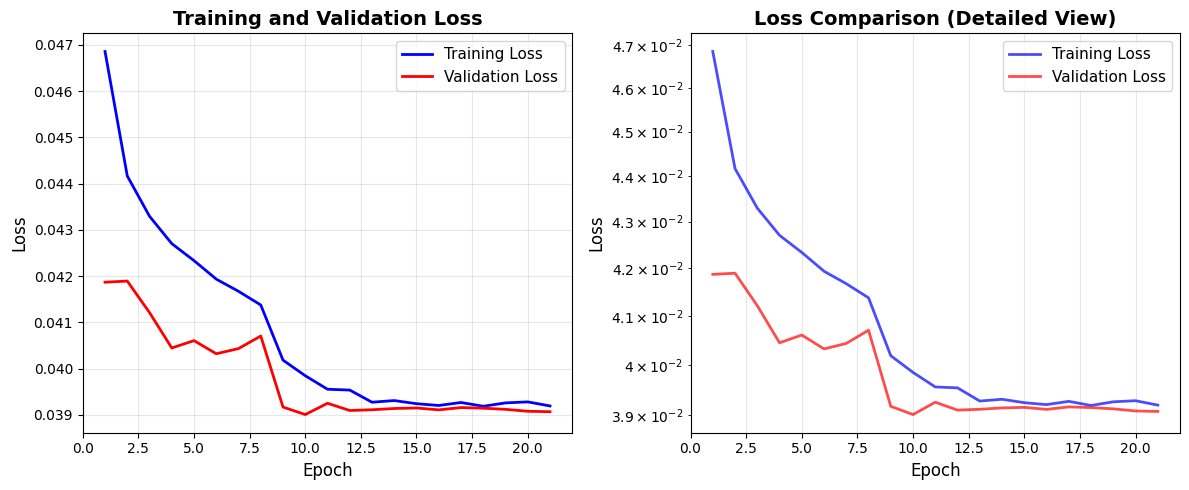


===== TRAINING SUMMARY =====
Final Training Loss: 0.0392
Final Validation Loss: 0.0391
Best Validation AUC: 0.8506
Total Epochs Trained: 21
Training stopped due to early stopping.


In [24]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [25]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

[Test]:   0%|          | 0/288 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d1c7d370040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d1c7d370040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[Test] Atelectasis AUC: 0.8146 | F1: 0.4116
[Test] Cardiomegaly AUC: 0.9325 | F1: 0.4793
[Test] Consolidation AUC: 0.7871 | F1: 0.2436
[Test] Edema AUC: 0.8841 | F1: 0.3019
[Test] Effusion AUC: 0.9015 | F1: 0.6048
[Test] Emphysema AUC: 0.9656 | F1: 0.5526
[Test] Fibrosis AUC: 0.8207 | F1: 0.1250
[Test] Hernia AUC: 0.9936 | F1: 0.7059
[Test] Infiltration AUC: 0.7044 | F1: 0.4073
[Test] Mass AUC: 0.9122 | F1: 0.4762
[Test] Nodule AUC: 0.7780 | F1: 0.3463
[Test] Pleural_Thickening AUC: 0.8124 | F1: 0.2583
[Test] Pneumonia AUC: 0.7229 | F1: 0.0678
[Test] Pneumothorax AUC: 0.8902 | F1: 0.3439
[Test] Avg AUC: 0.8514, Avg F1: 0.3803


In [26]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 0.0415
Avg AUROC : 0.8514
Avg F1    : 0.3803

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8146     0.4116     0.3883    
Cardiomegaly         0.9325     0.4793     0.3564    
Consolidation        0.7871     0.2436     0.3169    
Edema                0.8841     0.3019     0.3974    
Effusion             0.9015     0.6048     0.4216    
Emphysema            0.9656     0.5526     0.3198    
Fibrosis             0.8207     0.1250     0.3314    
Hernia               0.9936     0.7059     0.7221    
Infiltration         0.7044     0.4073     0.3760    
Mass                 0.9122     0.4762     0.4317    
Nodule               0.7780     0.3463     0.3452    
Pleural_Thickening   0.8124     0.2583     0.2924    
Pneumonia            0.7229     0.0678     0.2317    
Pneumothorax         0.8902     0.3439     0.2913    

Average Optimal Thresho

Generating predictions:   0%|          | 0/288 [00:00<?, ?it/s]

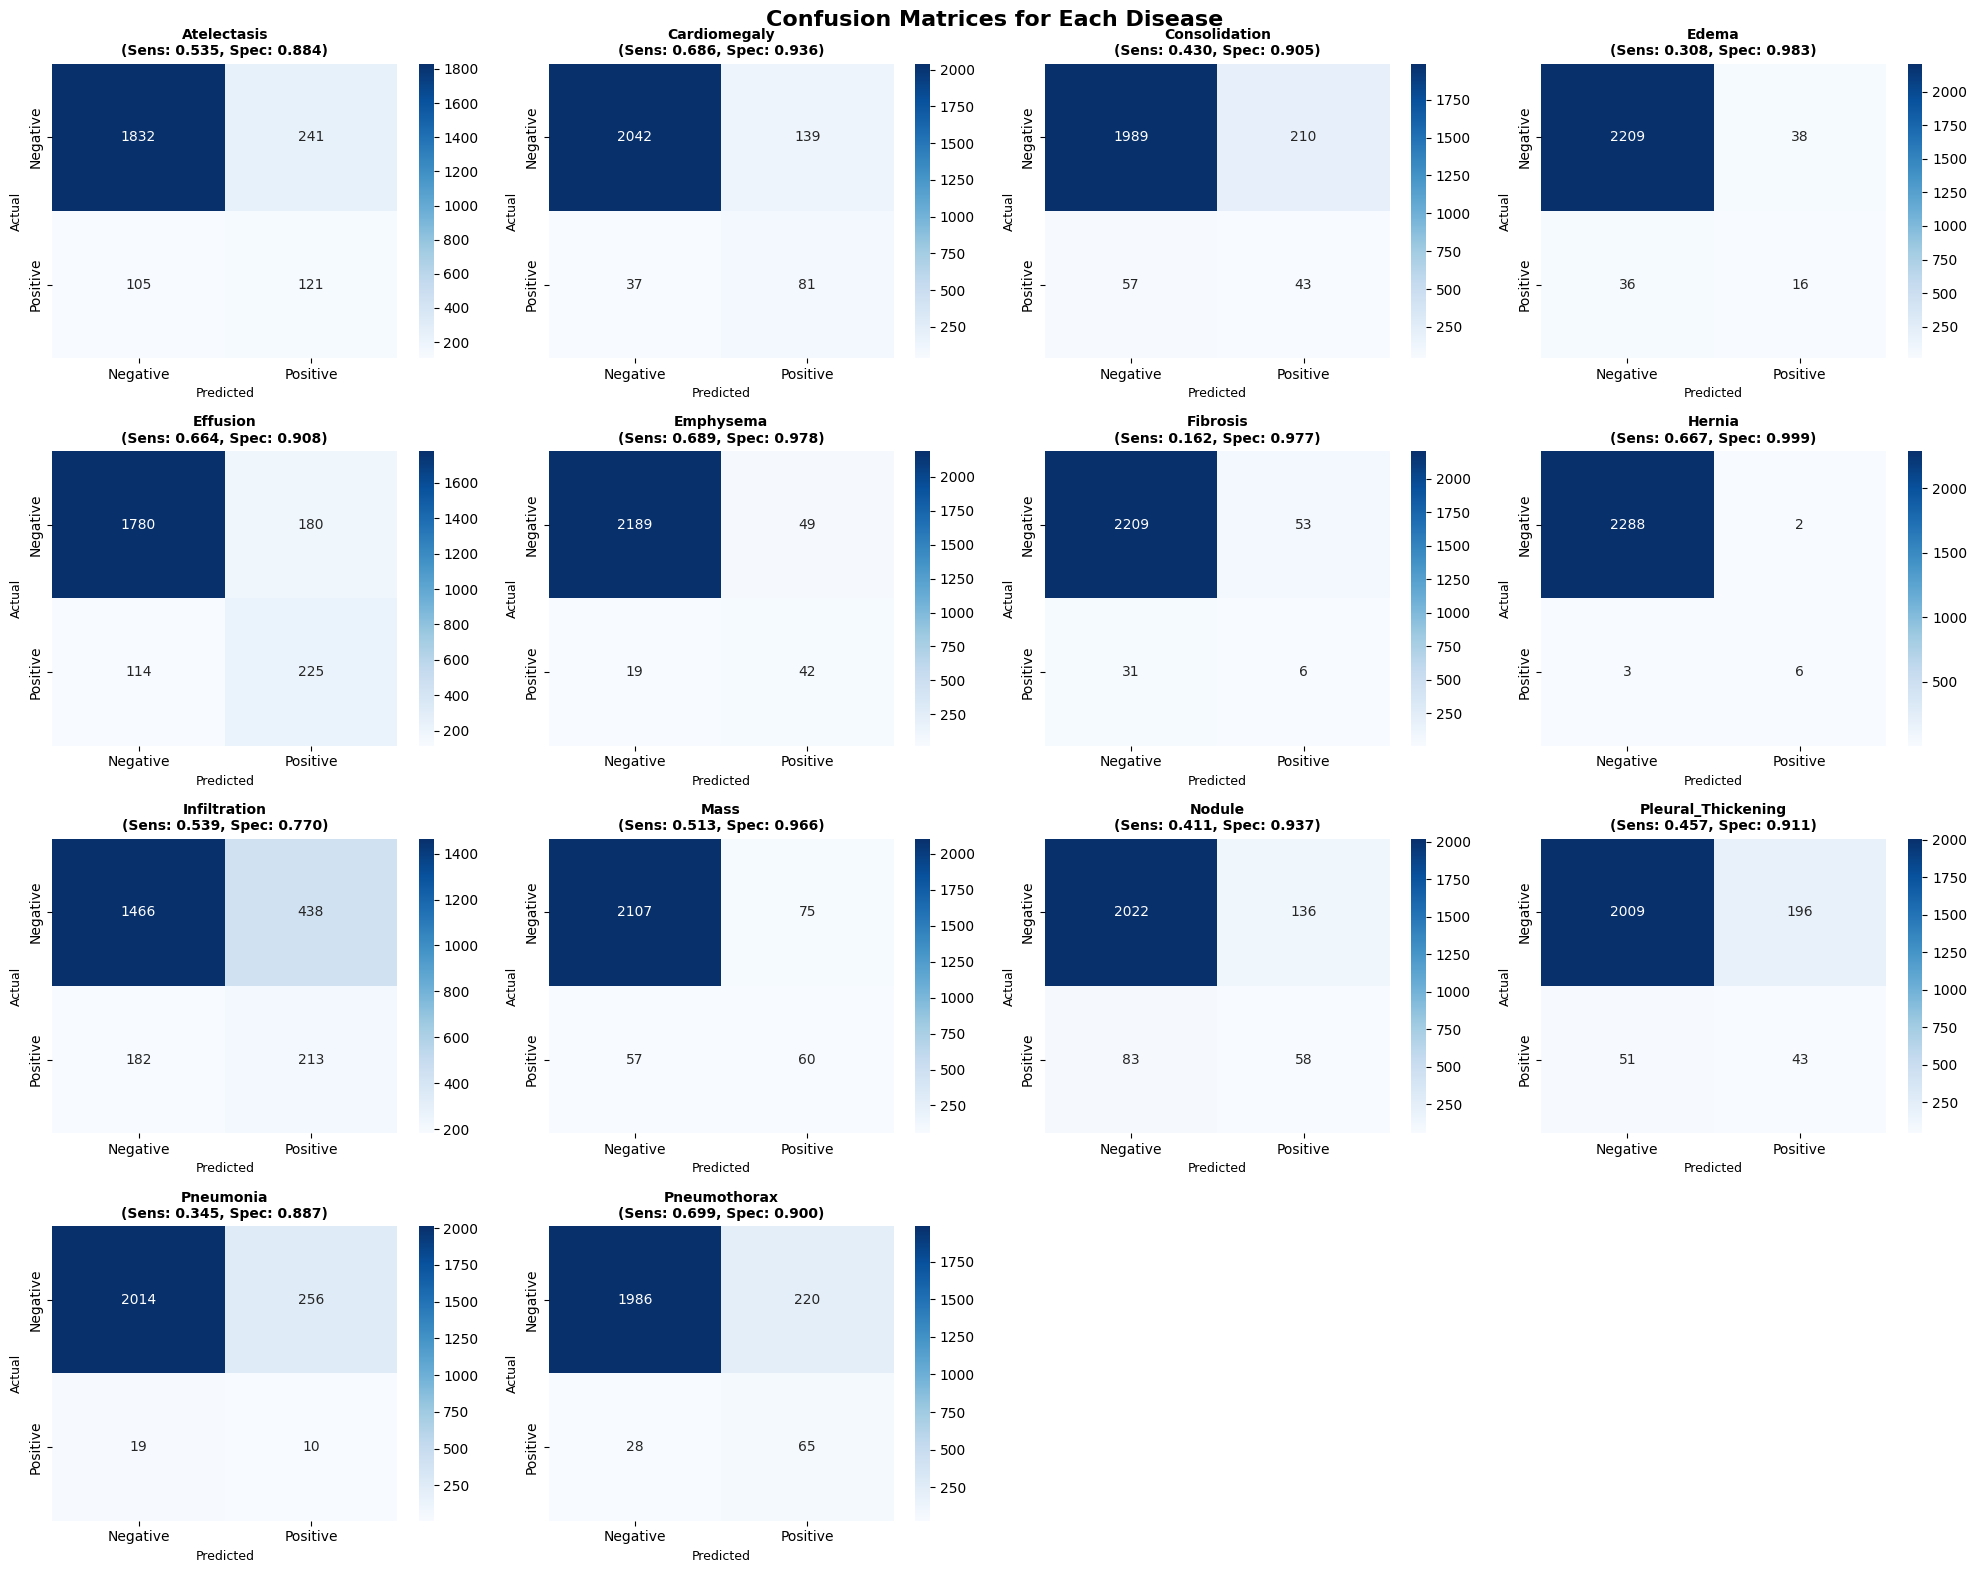

In [27]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [28]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          121    1832   241    105    0.535    0.884    0.334    0.946   
Cardiomegaly         81     2042   139    37     0.686    0.936    0.368    0.982   
Consolidation        43     1989   210    57     0.430    0.905    0.170    0.972   
Edema                16     2209   38     36     0.308    0.983    0.296    0.984   
Effusion             225    1780   180    114    0.664    0.908    0.556    0.940   
Emphysema            42     2189   49     19     0.689    0.978    0.462    0.991   
Fibrosis             6      2209   53     31     0.162    0.977    0.102    0.986   
Hernia               6      2288   2      3      0.667    0.999    0.750    0.999   
Infiltration         213    1466   438    182    0.539    0.770    0.327    0.890   
Ma